In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [64]:
def make_distr(mu, sigma):
    M = torch.FloatTensor([mu, mu])
    C = torch.FloatTensor([[sigma, 0],[0, sigma]])
    distr = torch.distributions.multivariate_normal.MultivariateNormal(M, C)
    return distr

In [65]:
d0 = make_distr(mu0, sigma0)
d1 = make_distr(mu1, sigma1)

In [66]:
d0.sample((5,))

tensor([[-2.1308, -2.1716],
        [-3.7775,  0.0489],
        [-1.9964, -1.9954],
        [-2.0107, -1.8491],
        [-0.9612, -3.6136]])

In [67]:
x_scale = np.linspace(-5, 5, 25)
y_scale = np.linspace(-5, 5, 25)
xx, yy = sp.meshgrid(x_scale, y_scale)
pos = np.dstack((xx, yy)).reshape(-1,2)

In [68]:
D0 = stats.multivariate_normal([mu0, mu0], sp.array([[sigma0, 0], [0, sigma0]]))
S0 = D0.pdf(pos)
D1 = stats.multivariate_normal([mu1, mu1], sp.array([[sigma1, 0], [0, sigma1]]))
S1 = D1.pdf(pos)

In [69]:
from mpl_toolkits.mplot3d import Axes3D

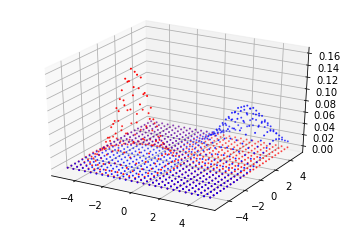

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], S0.reshape(-1, 1), color="r", s=1)
ax.scatter(pos[:, 0], pos[:, 1], S1.reshape(-1, 1), color="b", s=1)

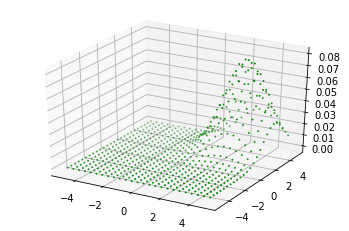

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
R = S1.reshape(-1, 1)/(S1.reshape(-1, 1)+S0.reshape(-1, 1))
ax.scatter(pos[:, 0], pos[:, 1], S1.reshape(-1, 1), color="g", s=1)

In [72]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [73]:
layer = nn.Linear(1, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.9388]), tensor(0.1372)]


In [81]:
net = nn.Sequential(nn.Linear(2, 10), nn.ReLU(), nn.Linear(10, 5), nn.Sigmoid(), nn.Linear(5, 1))
for p in net.parameters():
    print(p.data)
net_opt = optim.Adam(lr=1e-4,  weight_decay=1e-5, params=list(net.parameters()))

tensor([[ 0.6715, -0.6869],
        [ 0.2850, -0.2163],
        [-0.3191, -0.4265],
        [-0.4531,  0.3674],
        [ 0.0900,  0.2043],
        [-0.1746,  0.6018],
        [ 0.6267,  0.5129],
        [ 0.5453, -0.5445],
        [-0.1129, -0.1728],
        [ 0.2081, -0.1330]])
tensor([ 0.6168, -0.0738,  0.3805,  0.0175, -0.5751,  0.6705, -0.5669,  0.4302,
         0.6860, -0.5698])
tensor([[-0.2327,  0.1944, -0.1299, -0.1069,  0.2508, -0.0954,  0.0130,  0.0508,
          0.1626,  0.0279],
        [ 0.1563,  0.1403, -0.0361, -0.2902,  0.2771,  0.1713,  0.2827,  0.0999,
         -0.2869,  0.0195],
        [ 0.0158, -0.0858,  0.1138, -0.1989, -0.1763,  0.2661,  0.1926, -0.1061,
         -0.0297, -0.0095],
        [ 0.2481, -0.0543,  0.2353, -0.2677,  0.0624, -0.2691,  0.0418,  0.2373,
          0.0590,  0.2102],
        [-0.0654, -0.0631,  0.2370,  0.2848, -0.2126, -0.2348,  0.2563,  0.0955,
          0.1513, -0.2502]])
tensor([ 0.1223, -0.0435, -0.2595, -0.1746,  0.3026])
tensor([[0.1

In [82]:
log_freq = 500
for i in range(20000*3):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    net_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = net(x)
    loss = F.binary_cross_entropy_with_logits(out, y)
    loss.backward()
    net_opt.step()

Ошибка после 0 итераций: 0.788656
Ошибка после 1 итераций: 0.717581
Ошибка после 2 итераций: 0.657960
Ошибка после 3 итераций: 0.594041
Ошибка после 4 итераций: 0.527181
Ошибка после 5 итераций: 0.470384
Ошибка после 6 итераций: 0.424368
Ошибка после 7 итераций: 0.385928
Ошибка после 8 итераций: 0.350568
Ошибка после 9 итераций: 0.320186
Ошибка после 10 итераций: 0.294010
Ошибка после 11 итераций: 0.269859
Ошибка после 12 итераций: 0.247510
Ошибка после 13 итераций: 0.228158
Ошибка после 14 итераций: 0.210150
Ошибка после 15 итераций: 0.193508
Ошибка после 16 итераций: 0.178906
Ошибка после 17 итераций: 0.164507
Ошибка после 18 итераций: 0.151924
Ошибка после 19 итераций: 0.140559
Ошибка после 20 итераций: 0.129940
Ошибка после 21 итераций: 0.119527
Ошибка после 22 итераций: 0.110200
Ошибка после 23 итераций: 0.101998
Ошибка после 24 итераций: 0.094040
Ошибка после 25 итераций: 0.087030
Ошибка после 26 итераций: 0.080182
Ошибка после 27 итераций: 0.074571
Ошибка после 28 итераций: 0.06

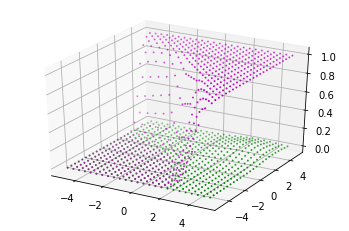

In [83]:
pos_tensor = torch.tensor(pos, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(net(pos_tensor)).numpy()
    fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
R = S1.reshape(-1, 1)/(S1.reshape(-1, 1)+S0.reshape(-1, 1))
ax.scatter(pos[:, 0], pos[:, 1], S1.reshape(-1, 1), color="g", s=1)
ax.scatter(pos[:, 0], pos[:, 1], dist.reshape(-1, 1), color="m", s=1)